In [286]:
import matplotlib.pyplot as plt
import pylab
import math
import numpy as np
import scipy
import cmath
from scipy import special
from scipy import integrate
from numpy.polynomial.hermite import hermval

In [367]:
num_points = 4000
n = 30
expansion_number=90
gs_morse = 1 #number of gs Morse wavefunctions that will overlap with excited states, should be dependent on boltzmann distribution
ex_morse = 41

n_max_gs = 41
n_max_ex = 41

#hartree energy unit
D_gs = 0.475217 #2.071824545e-18 J
D_ex = 0.20149  #8.78444853e-19 J

#bohr^-1 units
alpha_gs = 1.17199002 #6.20190409869e-11 meters^-1
alpha_ex = 1.23719524 #6.54695526318e-11 meters^-1

#bohr units'
shift_ex = 0.201444790427

#mass in a.u.
mu = 12178.1624678

'frequency in a.u.'
omega_gs = 0.01599479871665311 #6.61246943e14 Hz
omega_ex = 0.01099445915946515
# omega_gs = 0.010353662727838314 #4.28020304e14 rad (value when not divided by 2pi)

'Hartree units'
adiabatic =0.0734987


Ha_to_eV=27.211396132

In [368]:
def spring_const(alpha,D):
	return (alpha**2)*2*D

def mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu):
	omega_gs = np.sqrt(spring_const(alpha_gs,D_gs)/mu)/2*math.pi
	omega_ex = np.sqrt(spring_const(alpha_ex,D_ex)/mu)/2*math.pi
	return omega_gs,omega_ex

def compute_Harm_eval_n(omega,D,n):
	return omega*(n+0.5)-(omega**2/(4.0*D)*(n+0.5)**2.0)

def find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift):
	freq_gs = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[0]
	freq_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]
	E_max_gs=compute_Harm_eval_n(freq_gs,D_gs,n_max_gs) # compute the energies for the highest energy morse 
	E_max_ex=compute_Harm_eval_n(freq_ex,D_ex,n_max_ex) # state considered
	# find the two classical turning points for the ground state PES
	point1_gs = math.sqrt(2*E_max_gs/spring_const(alpha_gs,D_gs))
	point2_gs = -math.sqrt(2*E_max_gs/spring_const(alpha_gs,D_gs))
	
	point1_ex = math.sqrt(2*E_max_ex/spring_const(alpha_ex,D_ex))+shift
	point2_ex = -math.sqrt(2*E_max_ex/spring_const(alpha_ex,D_ex))+shift

	# now find the smallest value and the largest value
	start_point=min(point1_gs,point2_gs)
	end_point=max(point1_ex,point2_ex)
	return start_point,end_point



In [369]:
start_point=find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift_ex)[0]
end_point=find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift_ex)[1]

#mode frequency of each oscillator
omega_gs = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[0]
omega_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]

#quantum turning points, established from 10% increase of classical tp's due to tunneling
start_point=start_point-start_point*0.1
end_point= end_point+end_point*0.1
step_x=(end_point-start_point)/num_points
x_range = np.arange(start_point,end_point,step_x)

In [370]:
def Harm_wavefunc(x_range,omega,mu,n,shift):
	wavefunc=np.zeros((num_points,2))
	r_val=x_range*(math.sqrt(mu*omega))
	r_shift_val=shift*(math.sqrt(mu*omega))
	herm_coeffs = np.zeros(n+1)
	herm_coeffs[n] = 1
	norm=1/math.sqrt((2**n)*math.factorial(n))*(mu*omega/math.pi)**(0.25)
	#renormalize to prevent error buildup
	counter = 0.0
	for i in range(num_points):
		wavefunc[i,0]=start_point+counter*step_x
		counter = counter+1
	wavefunc[:,1] = norm*np.exp(-((r_val-r_shift_val)**2)/2)*np.polynomial.hermite.hermval(r_val-r_shift_val,herm_coeffs)
	psi_norm = integrate.simps(wavefunc[:,1]**2,dx=step_x)
	wavefunc[:,1] = wavefunc[:,1]/math.sqrt(psi_norm)
	
	return wavefunc

In [371]:
def Morse_wavefunc(num_points,start_point,end_point,D,alpha,mu,n,shift):
        # first start by filling array with position points:
        wavefunc=np.zeros((num_points,2))
        lamda=math.sqrt(2.0*D*mu)/(alpha)
        step_x=(end_point-start_point)/num_points
        denom=special.gamma(2.0*lamda-n)
        if np.isinf(denom):
                denom=10e280
        num=(math.factorial(n)*(2.0*lamda-2.0*n-1.0))
        normalization=math.sqrt(num/denom)
        counter=0
        for x in wavefunc:
                x[0]=start_point+counter*step_x
                r_val=(start_point+counter*step_x)*alpha
                r_shift_val=(shift)*alpha
                z_val=2.0*lamda*math.exp(-(r_val-r_shift_val))
                func_val=normalization*z_val**(lamda-n-0.5)*math.exp(-0.5*z_val)*special.assoc_laguerre(z_val,n,2.0*lamda-2.0*n-1.0)
                x[1]=func_val
                counter=counter+1

	# fix normalization regardless of value of denominator to avoid rounding errors
        wavefunc_sq=np.zeros(wavefunc.shape[0])
        wavefunc_sq[:]=wavefunc[:,1]*wavefunc[:,1]
        normalization=integrate.simps(wavefunc_sq,dx=step_x)
        for counter in range(wavefunc.shape[0]):
                wavefunc[counter,1]=wavefunc[counter,1]/math.sqrt(normalization)

        return wavefunc

**LC_coefficients function**

The LC_coefficients function below has two return outputs. The squared coefficcients are used as a failsafe to determine if your overlaps are caculated correctly. For any given function you are building with an LC of harmonic oscillators, the sum of their squared coefficients should approach 1 with increasing coeffs. For calculationsinvovling summing the coefficients you must use the "unsquared" list of coeffs.

In [372]:
def LC_coefficients(x_range,omega,num_points,start_point,end_point,D,alpha,mu,n,expansion_number,shift):
    morse = Morse_wavefunc(num_points,start_point,end_point,D,alpha,mu,n,shift)
    LC_coeffs = np.zeros(expansion_number)
    for i in range(expansion_number):
        LC_coeffs[i] = integrate.simps(morse[:,1]*Harm_wavefunc(x_range,omega,mu,i,shift)[:,1],x_range)
    return LC_coeffs

In [393]:

# coefficients = LC_coefficients(x_range,omega_ex,num_points,start_point,end_point,D_ex,alpha_ex,mu,n,expansion_number,shift_ex)
# plt.plot(coefficients)
print('coefficients:',LC_coefficients(x_range,omega_ex,num_points,start_point,end_point,D_ex,alpha_ex,mu,n,expansion_number,shift_ex))
print('coefficients sum SQ:',sum(LC_coefficients(x_range,omega_gs,num_points,start_point,end_point,D_ex,alpha_ex,mu,n,expansion_number,shift_ex)**2))
print('')

#sum of your squared overlap coefficients should approach convergence to 1 with increase in total states

coefficients: [ 9.95025728e-09 -5.77269244e-07 -1.52799360e-06  1.52011922e-05
  4.72242539e-05 -1.86837404e-04 -6.92045124e-04  1.32872585e-03
  6.04137174e-03 -5.95978723e-03 -3.43500612e-02  1.74109065e-02
  1.33246769e-01 -4.20082901e-02 -3.32058710e-01  7.66307464e-02
  5.43099506e-01 -3.16708939e-01  8.56696770e-02 -2.80243109e-01
 -6.52841082e-02  6.71901805e-02  1.38328896e-01  1.59578853e-01
  7.06440467e-02 -3.69164765e-02 -1.21806295e-01 -1.50344248e-01
 -1.14874188e-01 -3.79155648e-02  4.89443305e-02  1.14931477e-01
  1.40556469e-01  1.21830610e-01  6.82425518e-02 -2.20034920e-03
 -6.93408748e-02 -1.16436713e-01 -1.33689949e-01 -1.19432975e-01
 -7.92183841e-02 -2.35065732e-02  3.52368175e-02  8.53108982e-02
  1.17898126e-01  1.28268284e-01  1.16038504e-01  8.46359294e-02
  4.02133137e-02 -9.69844119e-03 -5.75378432e-02 -9.68534954e-02
 -1.23102961e-01 -1.34048882e-01 -1.29760052e-01 -1.12284793e-01
 -8.51092759e-02 -5.25332160e-02 -1.90771865e-02  1.10211204e-02
  3.4235147

In [374]:
def Linear_combo_wfs(x_range,omega,D,alpha,mu,n,expansion_number,shift):
	coefficients=LC_coefficients(x_range,omega,num_points,start_point,end_point,D,alpha,mu,n,expansion_number,shift)
	LC_func = np.zeros((num_points,expansion_number))
	for i in range (expansion_number):
		LC_func[:,i]=Harm_wavefunc(x_range,omega,mu,i,shift)[:,1]*coefficients[i]
	#print(LC_func)
	return LC_func.sum(axis=1)

In [375]:
def LC_func_overlaps(x_range,omega_gs,omega_ex,D_ex,alpha_ex,D_gs,alpha_gs,mu,gs_morse,ex_morse,expansion_number,shift):
	gs_LC_morse=np.zeros((num_points,gs_morse))
	ex_LC_morse=np.zeros((num_points,ex_morse))
	gs_ex_Mat=np.zeros((gs_morse,ex_morse))
	counter=0
	step0=start_point
	step1=start_point+step_x
	for i in range(gs_morse):
		gs_LC_morse[:,i]=Linear_combo_wfs(x_range,omega_gs,D_gs,alpha_gs,mu,i,expansion_number,0.0) #start_point+counter*step_x
	print('gs_LC_Morse',gs_LC_morse)
	
	for j in range(ex_morse):
		ex_LC_morse[:,j] = Linear_combo_wfs(x_range,omega_ex,D_ex,alpha_ex,mu,j,expansion_number,shift)
	print('ex_LC_Morse',ex_LC_morse)
	
	for k in range(gs_morse):
		for l in range(ex_morse):
			overlap=gs_LC_morse[:,k]*ex_LC_morse[:,l]
			gs_ex_Mat[k,l]=integrate.simps(gs_LC_morse[:,k]*ex_LC_morse[:,l],dx=step1-step0)
	return gs_ex_Mat


In [376]:
# print('MORSE LC OVERLAP MAT:', LC_func_overlaps(x_range,omega_gs,omega_ex,D_ex,alpha_ex,D_gs,alpha_gs,mu,gs_morse,ex_morse,expansion_number,shift_ex)**2)
# plt.plot(LC_func_overlaps(x_range,omega_gs,omega_ex,D_ex,alpha_ex,D_gs,alpha_gs,mu,gs_morse,ex_morse,expansion_number,shift_ex)[0,:]**2)

def transition_energy(omega_ex,D_ex,omega_gs,D_gs,n):
	E_gs=compute_Harm_eval_n(omega_gs,D_gs,n)
	E_ex=compute_Harm_eval_n(omega_ex,D_ex,n)
	return (E_ex-E_gs)+adiabatic

In [377]:
def energy_distribution(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse):
	max_abs = D_ex+transition_energy(omega_ex,D_ex,omega_gs,D_gs,0)+0.09#+transition_energy(omega_ex,D_ex,omega_gs,D_gs,0)#(D_ex+adiabatic)*Ha_to_eV-compute_Harm_eval_n(omega_gs,D_gs,0)*au_to_fs*hbar_in_eVfs#largest possible excitation energy
# 	freq_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]
	min_abs = transition_energy(omega_ex,D_ex,omega_gs,D_gs,0)#0-0 transition # compute the energies for the highest energy morse 
# 	max_abs = compute_Harm_eval_n(freq_ex,D_ex,n_max_ex)+transition_energy(omega_ex,D_ex,omega_gs,D_gs,0)# state considered
# 	vib_ex1 = compute_Harm_eval_n(omega_ex,D_ex,1)#+adiabatic*Ha_to_eV
# 	vib_ex0 = compute_Harm_eval_n(omega_ex,D_ex,0)
	'''doesnt take in to account the decrease in vibrational eigenvalue energy difference as state increases definitely a source of error 
	can we add a decay rate???'''
	E_vib=np.zeros(gs_morse*ex_morse)
	for i in range(gs_morse*ex_morse):
		E_vib[i]= compute_Harm_eval_n(omega_ex,D_ex,i)-compute_Harm_eval_n(omega_ex,D_ex,0) #energy difference between two vibrational harmonic eigenstates
	
	E_trans = np.zeros(gs_morse*ex_morse)
	E_range= np.zeros(num_points)
	E_stepx = (max_abs-min_abs)/num_points

	
	#populate E_trans with vibronic transition energies
	for i in range(gs_morse*ex_morse):
		if i == 0:
			E_trans[i]=min_abs #the zero position 
		else:
			E_trans[i]=min_abs + E_vib[i]
	
	#'populate E_range with energy grid over which to plot spectrum  (in eV)'
	for i in range(num_points):
		E_range[i] = (min_abs-(min_abs*.2))+i*E_stepx #subtracted 20% from min_abs to capture full peak width (min_abs-(min_abs*0.1))
		
	return E_trans,E_range

In [378]:
def gaussian_setup(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse):
	E_range = energy_distribution(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse)[1]
	E_trans = energy_distribution(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse)[0]
	s = 0.001 #arbitrary gaussian SD, causes linewidth to change
	full_function = np.zeros((num_points,gs_morse*ex_morse))
	for i in range(gs_morse*ex_morse):
		for k in range(num_points):
			full_function[k,i]=np.exp(-(E_range[k]-E_trans[i])**2/(2*s**2))

	return full_function


In [379]:
def plot_setup(x_range,alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse,expansion_number,shift):
	full_function = gaussian_setup(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse)
	overlap_coefs = LC_func_overlaps(x_range,omega_gs,omega_ex,D_ex,alpha_ex,D_gs,alpha_gs,mu,gs_morse,ex_morse,expansion_number,shift)
	overlap_function=np.zeros((num_points,gs_morse*ex_morse))
	sumed_function = np.zeros((num_points,1))
	for i in range(gs_morse):
		for j in range(ex_morse):
			overlap_function[:,j] = full_function[:,j]*overlap_coefs[i,j]**2
	print('overlap_func',overlap_function)
# 	for i in range(num_points):
# 		sumed_function[i] = sum(overlap_function[i,:])
	sumed_function = overlap_function.sum(axis=1)
	return sumed_function

In [380]:
def absorbance_correction(x_range,alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse,shift):
	E_range = energy_distribution(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse)[1]
	summed_function = plot_setup(x_range,alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse,expansion_number,shift)
	adjusted_plot=np.zeros((summed_function.shape[0],1))
	for i in range(num_points):
		adjusted_plot[i]= summed_function[i]*2.7347*E_range[i]*Ha_to_eV#*40.0*math.pi**2.0*fine_struct*E_range[i]/(3.0*math.log(10.0))*2.7347
	return adjusted_plot

In [381]:
E_range = energy_distribution(alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse)[1]
# plot_ready_function =absorbance_correction(x_range,alpha_gs,D_gs,alpha_ex,D_ex,mu,gs_morse,ex_morse,shift_ex)
# print('plot_ready_func:',plot_ready_function.shape)


In [382]:
def write_output(plot_ready_function,E_range):
	spectrum_file = open('./Linear_combo.out', 'w')
	xarray = np.array(E_range*Ha_to_eV)
	yarray = np.array(plot_ready_function)
	data = np.column_stack([xarray,yarray])
	np.savetxt(spectrum_file,data,fmt=['%10.10f','%10.10f'])
	spectrum_file.close()
	return spectrum_file

In [ ]:
my_file = write_output(plot_ready_function,E_range)


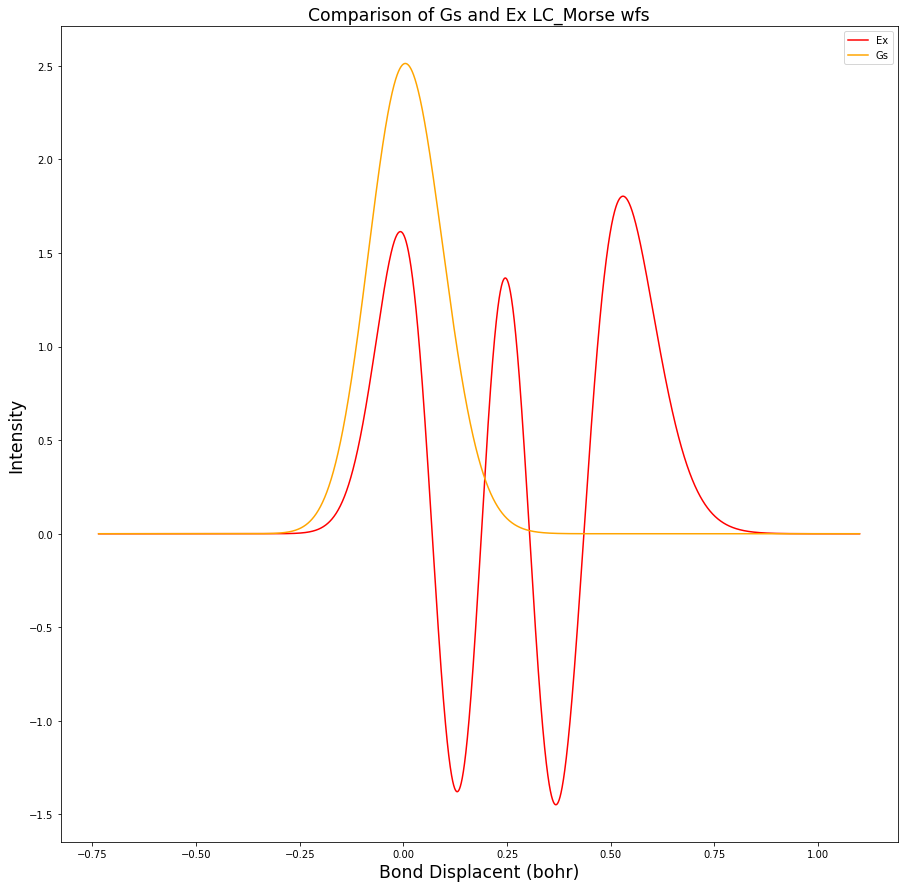

In [408]:
Morse_from_LC_of_Harm_osc_10n=Linear_combo_wfs(x_range,omega_gs,D_gs,alpha_gs,mu,n,expansion_number,0.0)
Morse_gs_v0 = Morse_wavefunc(num_points,start_point,end_point,D_gs,alpha_gs,mu,n,0)
Harmonic_v0 = Harm_wavefunc(x_range,omega_gs,mu,n,0)

x = x_range


fig,ax = plt.subplots(figsize=(15,15))


############# to plot wavefunctions########################
# y1 = Morse_from_LC_of_Harm_osc_10n[:]
# y2 = Morse_gs_v0[:,1]
# y3 = Harmonic_v0[:,1]

# line1 = ax.plot(x,y1,color='red',label='n=30')
# line2 = ax.plot(x,y2,color='orange',label='Exact')
# line3 = ax.plot(x,y3,color='magenta',label='Harm')

# plt.title('Harmonic LC of Morse v=10',fontsize='xx-large')
# ax.set_xlabel('Bond Displacent (bohr)',fontsize='xx-large')
# ax.set_ylabel('Intensity',fontsize='xx-large')

################to plot vibronic spectrum###################
# line4 = ax.plot(E_range*Ha_to_eV,plot_ready_function)
# plt.title('LC Morse Vibronic Spectrum',fontsize='xx-large')
# ax.set_xlabel('Energy (eV)',fontsize='xx-large')
# ax.set_ylabel('Intensity',fontsize='xx-large')

################to plot overlapping wavefuntions ###########
Morse_ex=Linear_combo_wfs(x_range,omega_ex,D_ex,alpha_ex,mu,4,expansion_number,shift_ex)
Morse_gs=Linear_combo_wfs(x_range,omega_gs,D_gs,alpha_gs,mu,0,expansion_number,0.0)
line1 = ax.plot(x,Morse_ex,color='red',label='Ex')
line2 = ax.plot(x,Morse_gs,color='orange',label='Gs')
plt.title('Comparison of Gs and Ex LC_Morse wfs',fontsize='xx-large')
ax.set_xlabel('Bond Displacent (bohr)',fontsize='xx-large')
ax.set_ylabel('Intensity',fontsize='xx-large')

ax.legend()
plt.show()
